In [7]:
# monitored data
# y_mon, cumulative_sizes_mon, burst_mon
import numpy as np
import pickle

USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS = 950

# Load data
with open("mon_standard.pkl", 'rb') as fi:
    mon_data = pickle.load(fi)
    
y_mon = [] # Array to store the site of each instance - 19,000 instances, e.g., [0, 0, 0, 0, 0, 0, ..., 94, 94, 94, 94, 94]
cumulative_sizes_mon = []  
burst_mon = [] 

for i in range(TOTAL_URLS):
    if USE_SUBLABEL: 
        label = i
    else: 
        label = i // URL_PER_SITE 
    for sample in mon_data[i]: # mon_data[i] : 20개 * subURL(10개) * 95 websites -> 19000개
        cumulative_sizes = []  
        burst_seq = []
        cumulative_size = 0 
        burst_sum=0
        burst_check=-1
        for c in sample:
            dr = 1 if c > 0 else -1
            cumulative_size += dr * 512
            cumulative_sizes.append(cumulative_size)
            if(burst_check * dr > 0) : 
                burst_sum += dr * 512
            else : 
                burst_seq.append(burst_sum)
                burst_check = -1 * burst_check
                burst_sum = dr * 512
        burst_seq.append(burst_sum)
        
        cumulative_sizes_mon.append(cumulative_sizes)
        burst_mon.append(burst_seq)
        y_mon.append(label)
        
size = len(y_mon)
print(f'Total samples: {size}')

Total samples: 19000


In [18]:
# unmonitored data
# cumulative_sizes_unmon, burst_unmon
import numpy as np
import pickle

TOTAL_UNMON_URLS = 10000  

with open("unmon_standard10.pkl", 'rb') as fi:
    unmon_data = pickle.load(fi)

burst_unmon = []
cumulative_sizes_unmon = []
y_unmon = []

for i in range(5000):
    cumulative_sizes = []  
    burst_seq = []
    cumulative_size = 0
    burst_sum = 0
    burst_check = -1
    for c in unmon_data[i]:
        dr = 1 if c > 0 else -1
        cumulative_size += dr * 512
        cumulative_sizes.append(cumulative_size)
        if(burst_check * dr > 0) :
            burst_sum += dr * 512
        else :
            burst_seq.append(burst_sum)
            burst_check = -1 * burst_check
            burst_sum = dr * 512
    burst_seq.append(burst_sum)
    
    cumulative_sizes_unmon.append(cumulative_sizes)
    burst_unmon.append(burst_seq)
    y_unmon.append(-1)

In [19]:
print(len(y_unmon))

5000


In [20]:
# concat monitored and unmonitored data
cumulative_sizes = cumulative_sizes_mon + cumulative_sizes_unmon
burst = burst_mon + burst_unmon

# assign labels for binary classification
y_bin = np.concatenate((np.ones(len(y_mon)), -1 * np.ones(len(y_unmon))))

# assign labels for multi-class classification
y_multi = np.concatenate((y_mon, 95 * np.ones(len(y_unmon))))

In [21]:
# add padding to cumulative sizes and burst lists
max_length_c = max(max(len(arr) for arr in cumulative_sizes), max(len(arr) for arr in cumulative_sizes))
max_length_b = max(max(len(arr) for arr in burst), max(len(arr) for arr in burst))

def pad_sequence(sequence, max_length):
    return sequence + [0] * (max_length - len(sequence))

cumulative_sizes = [pad_sequence(arr, max_length_c) for arr in cumulative_sizes]
burst = [pad_sequence(arr, max_length_b) for arr in burst]

In [24]:
print(max_length_c)
print(max_length_b)
print(len(cumulative_sizes))
print(len(burst))

9993
1563
24000
24000


In [25]:
from sklearn.model_selection import train_test_split

# split train and test data
# cumultative sizes 
# binary, multi-class
X_train_c_bin, X_test_c_bin, y_train_c_bin, y_test_c_bin = train_test_split(cumulative_sizes, y_bin, test_size=0.2, random_state=42)
X_train_c_multi, X_test_c_multi, y_train_c_multi, y_test_c_multi = train_test_split(cumulative_sizes, y_multi, test_size=0.2, random_state=42)

# burst
# binary, multi-class
X_train_b_bin, X_test_b_bin, y_train_b_bin, y_test_b_bin = train_test_split(burst, y_bin, test_size=0.2, random_state=42)
X_train_b_multi, X_test_b_multi, y_train_b_multi, y_test_b_multi = train_test_split(burst, y_multi, test_size=0.2, random_state=42)

--- Binary Classification: Cumulative Sizes Binary, SVM ---
True Positive Rate: 0.7891666666666667
Precision: 0.7891666666666667
False Positive Rate: 0.21083333333333332


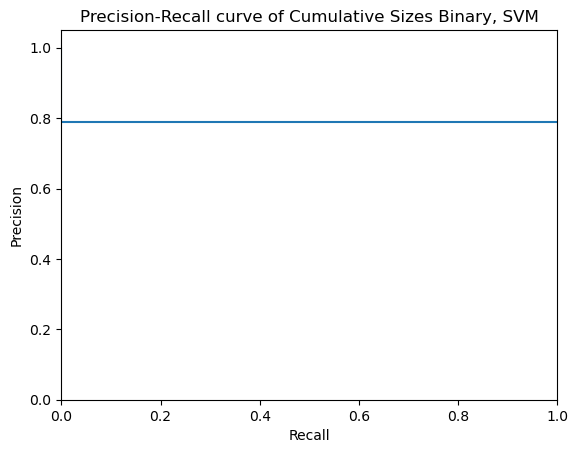

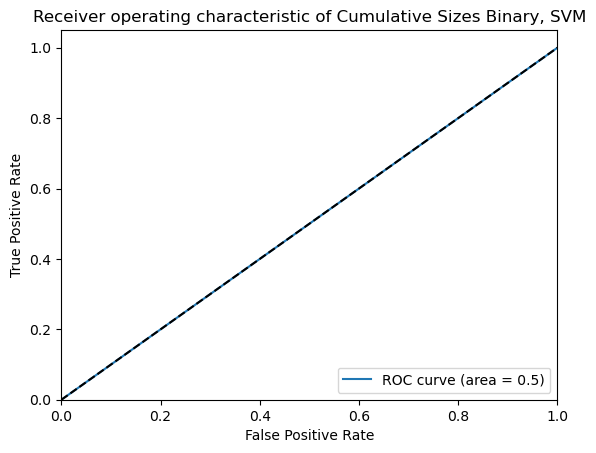

--- Binary Classification: Burst Binary, SVM ---
True Positive Rate: 0.8166666666666667
Precision: 0.8166666666666667
False Positive Rate: 0.18333333333333335


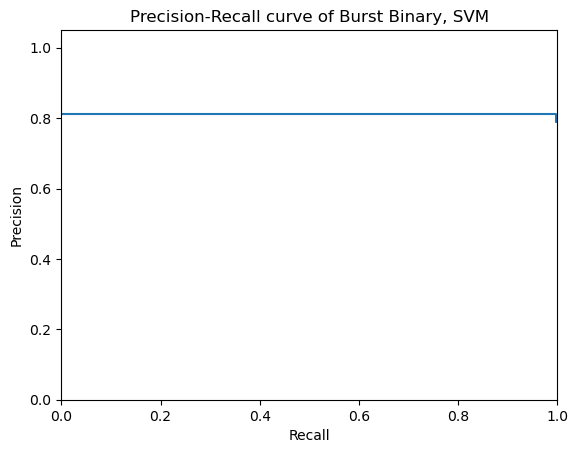

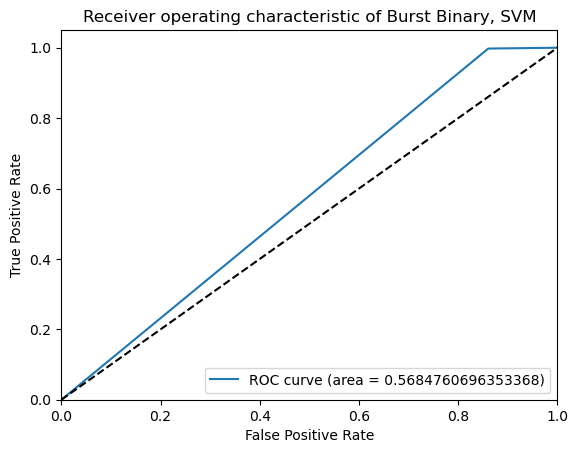

In [33]:
# SVM
# binary classification
# train and evaluate
from sklearn import svm
from sklearn.metrics import precision_recall_curve, roc_curve, auc, precision_score, recall_score
import matplotlib.pyplot as plt

model_svm = svm.SVC()
model_name = 'SVM'

datasets_bin = [(X_train_c_bin, X_test_c_bin, y_train_c_bin, y_test_c_bin),
                (X_train_b_bin, X_test_b_bin, y_train_b_bin, y_test_b_bin)]

dataset_names = ['Cumulative Sizes Binary', 'Burst Binary']

for j, (X_train, X_test, y_train, y_test) in enumerate(datasets_bin):
    # train the model
    model_svm.fit(X_train, y_train)
    
    # prediction
    y_pred = model_svm.predict(X_test)
    
    # calculate the evaluate metrics
    # tpr
    tpr = recall_score(y_test, y_pred, average='micro')
    
    # precision
    precision = precision_score(y_test, y_pred, average='micro')
    print(f'--- Binary Classification: {dataset_names[j]}, {model_name} ---')
    print(f'True Positive Rate: {tpr}')
    print(f'Precision: {precision}')

    fpr = 1 - tpr
    print(f'False Positive Rate: {fpr}')

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall curve of {dataset_names[j]}, {model_name}')
    plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic of {dataset_names[j]}, {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [34]:
# SVM
# multi-class classification
# train and evaluate
from sklearn import svm
from sklearn.metrics import classification_report

model_svm = svm.SVC(decision_function_shape='ovo')
model_name = 'SVM'

datasets_multi = [(X_train_c_multi, X_test_c_multi, y_train_c_multi, y_test_c_multi),
                  (X_train_b_multi, X_test_b_multi, y_train_b_multi, y_test_b_multi)]

dataset_names = ['Cumulative Sizes Multi', 'Burst Multi']

for j, (X_train, X_test, y_train, y_test) in enumerate(datasets_multi):
    # train the model
    model_svm.fit(X_train, y_train)
    
    # prediction
    y_pred = model_svm.predict(X_test)
    
    print(f'--- Multi-Class Classification: {dataset_names[j]}, {model_name} ---')
    print(classification_report(y_test, y_pred))

--- Multi-Class Classification: Cumulative Sizes Multi, SVM ---
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        32
         1.0       0.00      0.00      0.00        48
         2.0       0.00      0.00      0.00        38
         3.0       0.00      0.00      0.00        36
         4.0       0.00      0.00      0.00        36
         5.0       0.00      0.00      0.00        39
         6.0       0.00      0.00      0.00        33
         7.0       0.00      0.00      0.00        41
         8.0       0.00      0.00      0.00        35
         9.0       0.00      0.00      0.00        27
        10.0       0.00      0.00      0.00        44
        11.0       0.00      0.00      0.00        48
        12.0       0.00      0.00      0.00        41
        13.0       0.00      0.00      0.00        47
        14.0       0.00      0.00      0.00        36
        15.0       0.00      0.00      0.00        42
        16.0     

/Users/joonghyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joonghyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joonghyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- Multi-Class Classification: Burst Multi, SVM ---
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        32
         1.0       1.00      0.12      0.22        48
         2.0       0.67      0.05      0.10        38
         3.0       1.00      0.28      0.43        36
         4.0       0.90      0.50      0.64        36
         5.0       0.50      0.03      0.05        39
         6.0       0.72      0.39      0.51        33
         7.0       0.57      0.59      0.58        41
         8.0       1.00      0.03      0.06        35
         9.0       0.56      0.19      0.28        27
        10.0       1.00      0.07      0.13        44
        11.0       0.88      0.44      0.58        48
        12.0       0.78      0.61      0.68        41
        13.0       0.00      0.00      0.00        47
        14.0       0.00      0.00      0.00        36
        15.0       0.44      0.10      0.16        42
        16.0       0.00     

/Users/joonghyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joonghyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joonghyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# random forest
# binary classification
# train and evaluate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# RandomForest model
model_rf = RandomForestClassifier()
model_name = 'RandomForest'

datasets_bin = [(X_train_c_bin, X_test_c_bin, y_train_c_bin, y_test_c_bin),
                (X_train_b_bin, X_test_b_bin, y_train_b_bin, y_test_b_bin)]

dataset_names = ['Cumulative Sizes Binary', 'Burst Binary']

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10]  # Minimum number of samples required to split an internal node
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, scoring='accuracy')

for j, (X_train, X_test, y_train, y_test) in enumerate(datasets_bin):
    
    # Fit GridSearchCV and train the model with the best parameters
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    
    # train the model
    model_rf.set_params(**best_params)
    
    # prediction
    y_pred = model_rf.predict(X_test)
    
    # tpr
    tpr = recall_score(y_test, y_pred, average='micro')
    
    # precision
    precision = precision_score(y_test, y_pred, average='micro')
    print(f'--- Binary Classification: {dataset_names[j]}, {model_name} ---')
    print(f'True Positive Rate: {tpr}')
    print(f'Precision: {precision}')

    fpr = 1 - tpr
    print(f'False Positive Rate: {fpr}')

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall curve of {dataset_names[j]}, {model_name}')
    plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic of {dataset_names[j]}, {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [32]:
# random forest
# multi-class classification
# train and evaluate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# RandomForest model
model_rf = RandomForestClassifier()
model_name = 'RandomForest'

datasets_multi = [(X_train_c_multi, X_test_c_multi, y_train_c_multi, y_test_c_multi),
                  (X_train_b_multi, X_test_b_multi, y_train_b_multi, y_test_b_multi)]

dataset_names = ['Cumulative Sizes Multi', 'Burst Multi']

for j, (X_train, X_test, y_train, y_test) in enumerate(datasets_multi):
    # train the model
    model_rf.fit(X_train, y_train)
    
    # prediction
    y_pred = model_rf.predict(X_test)
    
    print(f'--- Multi-Class Classification: {dataset_names[j]}, {model_name} ---')
    print(classification_report(y_test, y_pred))

--- Multi-Class Classification: Cumulative Sizes Multi, RandomForest ---
              precision    recall  f1-score   support

         0.0       0.96      0.84      0.90        32
         1.0       0.95      0.85      0.90        48
         2.0       0.88      0.97      0.93        38
         3.0       0.89      0.89      0.89        36
         4.0       0.97      0.97      0.97        36
         5.0       0.90      0.97      0.94        39
         6.0       0.92      1.00      0.96        33
         7.0       0.80      0.98      0.88        41
         8.0       0.94      0.89      0.91        35
         9.0       0.78      0.93      0.85        27
        10.0       1.00      0.82      0.90        44
        11.0       0.95      0.85      0.90        48
        12.0       0.90      0.88      0.89        41
        13.0       0.87      0.70      0.78        47
        14.0       0.97      0.89      0.93        36
        15.0       0.87      0.98      0.92        42
        

/Users/joonghyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


--- Binary Classification: Cumulative Sizes Binary, KNN ---
True Positive Rate: 0.7795833333333333
Precision: 0.7795833333333333
False Positive Rate: 0.2204166666666667


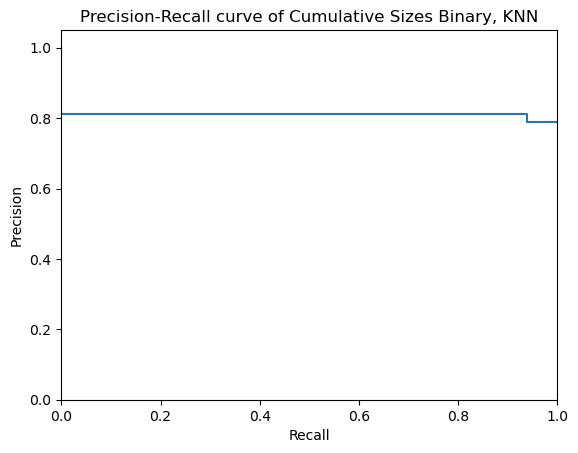

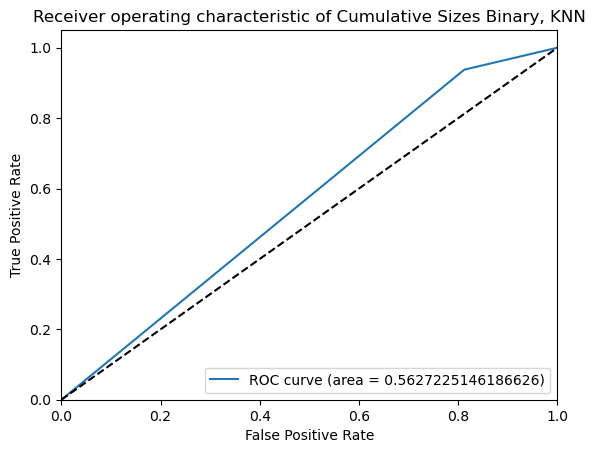

/Users/joonghyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


--- Binary Classification: Bursts Binary, KNN ---
True Positive Rate: 0.7952083333333333
Precision: 0.7952083333333333
False Positive Rate: 0.2047916666666667


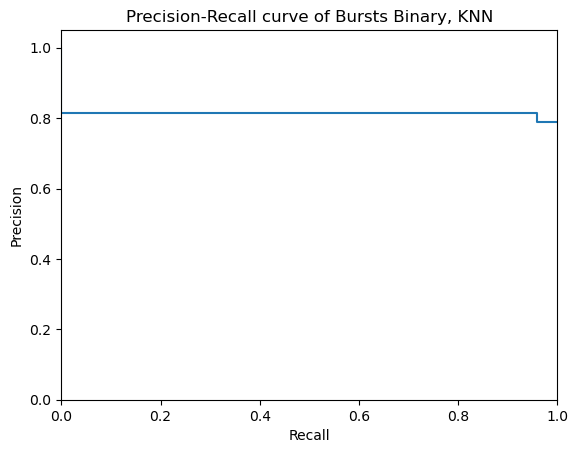

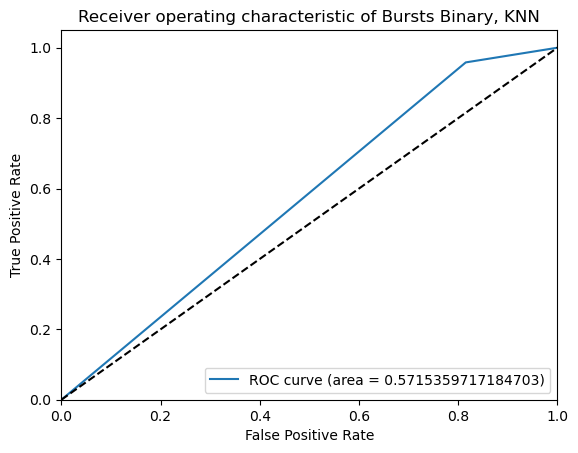

In [26]:
# KNN
# binary classification
# train and evaluate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc, precision_score, recall_score
import matplotlib.pyplot as plt

# KNN model
model_knn = KNeighborsClassifier()
model_name = 'KNN'

datasets_bin = [(X_train_c_bin, X_test_c_bin, y_train_c_bin, y_test_c_bin),
                (X_train_b_bin, X_test_b_bin, y_train_b_bin, y_test_b_bin)]

dataset_names = ['Cumulative Sizes Binary', 'Burst Binary']

for j, (X_train, X_test, y_train, y_test) in enumerate(datasets_bin):
    # train the model
    model_knn.fit(X_train, y_train)
    
    # prediction
    y_pred = model_knn.predict(X_test)
    
    # calculate the evaluate metrics
    # tpr
    tpr = recall_score(y_test, y_pred, average='micro')
    
    # precision
    precision = precision_score(y_test, y_pred, average='micro')
    print(f'--- Binary Classification: {dataset_names[j]}, {model_name} ---')
    print(f'True Positive Rate: {tpr}')
    print(f'Precision: {precision}')

    fpr = 1 - tpr
    print(f'False Positive Rate: {fpr}')

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall curve of {dataset_names[j]}, {model_name}')
    plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic of {dataset_names[j]}, {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [30]:
# KNN
# multi-class classification
# train and evaluate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# KNN model
model_knn = KNeighborsClassifier()
model_name = 'KNN'

datasets_multi = [(X_train_c_multi, X_test_c_multi, y_train_c_multi, y_test_c_multi),
                  (X_train_b_multi, X_test_b_multi, y_train_b_multi, y_test_b_multi)]

dataset_names = ['Cumulative Sizes Multi', 'Burst Multi']

for j, (X_train, X_test, y_train, y_test) in enumerate(datasets_multi):

    # train the model
    model_knn.fit(X_train, y_train)
    
    # prediction
    y_pred = model_knn.predict(X_test)
    
    print(f'--- Multi-Class Classification: {dataset_names[j]}, {model_name} ---')
    print(classification_report(y_test, y_pred))

/Users/joonghyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


--- Multi Classification: Cumulative Sizes Multi, KNN ---
Precision: 0.3304166666666667
--- Multi-Class Classification: Cumulative Sizes Multi, KNN ---
              precision    recall  f1-score   support

         0.0       0.11      0.28      0.16        32
         1.0       0.17      0.21      0.19        48
         2.0       0.44      0.71      0.55        38
         3.0       0.36      0.56      0.44        36
         4.0       0.10      0.14      0.11        36
         5.0       0.14      0.36      0.20        39
         6.0       0.26      0.48      0.34        33
         7.0       0.12      0.17      0.14        41
         8.0       0.27      0.49      0.34        35
         9.0       0.16      0.41      0.23        27
        10.0       0.19      0.27      0.23        44
        11.0       0.22      0.23      0.22        48
        12.0       0.52      0.66      0.58        41
        13.0       0.12      0.17      0.14        47
        14.0       0.21      0.42    

/Users/joonghyeon/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
